In [1]:
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
import numpy as np
import os

BASE_DIR = '/home/wsgh/research-projects/universal-conditional-ddpm/video-diffusion/'

In [14]:
import wandb


class IdentityDict(dict):
    def __init__(self, d):
        for k, v in d.items():
            self[k] = v
    def __getitem__(self, k):
        if k in self:
            return super().__getitem__(k)
        else:
            return k

nice_mode_names = IdentityDict({
    'autoreg': 'Autoregressive',
    'adaptive-autoreg': 'Adaptive autoregressive',
    'adaptive-hierarchy-2': 'Adaptive hierarchy-2',
    'independent': 'Only original observations',
    'mixed-autoreg-independent': 'Mixed',
    'hierarchy-2': 'Hierarchy-2',
    'hierarchy-3': 'Hierarchy-3',
    'hierarchy-4': 'Hierarchy-4',
    'hierarchy-5': 'Hierarchy-5',
    'really-independent': 'Independent',
    'cwvae': 'CWVAE',
    'differently-spaced-groups': 'Training distribution',
})


def parse_run(path):
    relative_path = Path(str(path).replace(BASE_DIR, ""))
    results, *subdirs, wandb_id, ckpt_name, inference_mode, _ = relative_path.parts
    assert results == 'results'
    mode, max_frames, step_size, T, obs_length = inference_mode.split('_')
    max_frames, step_size, T, obs_length = map(eval, [max_frames, step_size, T, obs_length])
    mode = nice_mode_names[mode]
    return dict(subdirs=subdirs, wandb_id=wandb_id, ckpt_name=ckpt_name,
                mode=mode, max_frames=max_frames, step_size=step_size, T=T, obs_length=obs_length)

def pad_to_len(s, l):
    return s + ' '*max(0, l-len(s))

def directory(path):
    return path if path.is_dir() else path.parent

def first_n(array, n):
    assert len(array) >= n
    return array[:n]

def format_mean_std(mean, std, n=None):
    s = f"{mean:.2f} +- {std:.3f}"
    if n is not None:
        s += f" ({n} seeds)"
    return s


class DB:
    def __init__(self, data=[]):
        if len(data) == 0:
            self.data = []
            for path in self.get_dirs():
                self.add_from_path(path)
        else:
            self.data = data
            
    def add_from_path(self, path):
        self.data.append({"path": path, "config": parse_run(path), **self.get_data(path)})

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    def __iter__(self):
        return iter(self.data)

    def query(self, **kwargs):
        return ExpDB([x for x in self.data if all([x["config"][k] == v for (k,v) in kwargs.items()])])

    def sort(self, keys):
        if isinstance(keys, str):
            self.sort([keys])
        self.data.sort(key=lambda x: [x["config"][k] for k in keys])
        
    def get_sorted(self, keys):
        if isinstance(keys, str):
            return self.get_sorted([keys])
        return ExpDB(data=sorted(self.data, key=lambda x: [x["config"][k] for k in keys]))

    def print_config(self):
        for x in self.data:
            print(x["config"])
            
    def get_data(self, path):
        raise NotImplementedError


class ElboDB(DB):
    
    def get_dirs(self):
        paths = Path(BASE_DIR).glob('results/**/elbos/')
        return [p for p in paths]
    
    def get_data(self, path):
        i = 0
        while os.path.exists(path / f"elbo_{i}.pkl"):
            data_i = pickle.load(open(path / f"elbo_{i}.pkl", 'rb'))
            if i == 0:
                data = {k: [] for k in data_i}
            for k in data:
                data[k].append(data_i[k])
            i += 1
        if i == 0:
            print('WARNING: failed', str(path))
            raise Exception
        return {'data': {k: np.stack(v, axis=0) for k, v in data.items()}}


class MetricDB(DB):

    def get_dirs(self):
        paths = Path(BASE_DIR).glob('results/**/metrics_*.pkl')  
        return [p for p in paths]

    def get_data(self, path):
        fname = path.parts[-1]
        n_videos, n_samples, video_length = fname.split('_')[1].split('.')[0].split('-')
        return {'data': pickle.load(open(path, "rb")), 'n_videos': n_videos,
                'n_samples': n_samples, 'video_length': video_length}

In [15]:
elbo_db = ElboDB()
metric_db = MetricDB()

# Ablations on RPE net:

In [4]:
class IDHasRPENet(dict):
    def __init__(self):
        self.api = wandb.Api()
        
    def __getitem__(self, id):
        if id in self:
            return super().__getitem__(id)
        else:
            self[id] = self.api.run(f"universal-conditional-ddpm/video-diffusion/{id}").config['use_rpe_net']
            return self[id]
id_to_rpe_net = IDHasRPENet()

### MineRL

In [5]:
minerl_ablation_elbo_db = [i for i in elbo_db if 'minerl-rpe-net-ablation' in i['config']['subdirs']]
mazes_ablation_elbo_db = [i for i in elbo_db if 'mazes-rpe-net-ablation' in i['config']['subdirs']]

def get_elbo_mean_std(db, has_rpe_net, metric='total_bpd'):
    relevant_data = []
    for run in db:
        if id_to_rpe_net[run['config']['wandb_id']] == has_rpe_net:
            data = first_n(run['data'][metric], n=100).sum(axis=1).mean(axis=0)
            relevant_data.append(data)
    relevant_data = np.array(relevant_data)
    assert relevant_data.ndim == 1
    return relevant_data.mean(), relevant_data.std(), len(relevant_data)

minerl_training_elbo_db = [i for i in minerl_ablation_elbo_db if i['config']['mode'] == 'Training distribution']
print('\nELBOs\n')
print('With RPE net')
print(format_mean_std(*get_elbo_mean_std(minerl_training_elbo_db, has_rpe_net=True)))
print('Without RPE net')
print(format_mean_std(*get_elbo_mean_std(minerl_training_elbo_db, has_rpe_net=False)))


ELBOs

With RPE net
24.82 +- 8.946 (3 seeds)
Without RPE net
19.06 +- 0.776 (3 seeds)


In [7]:
# minerl_ablation_with_rpe_net_db = [run for run in minerl_ablation_metric_db if id_to_rpe_net[run['config']['wandb_id']]]
# minerl_ablation_without_rpe_net_db = [run for run in minerl_ablation_metric_db if not id_to_rpe_net[run['config']['wandb_id']]]

# def get_fvd(db):
#     relevant_data = []
#     for run in db:
#         data = run['data']['fvd'].mean()
#         relevant_data.append(data)
#     relevant_data = np.array(relevant_data)
#     assert relevant_data.ndim == 1
#     return relevant_data.mean(), relevant_data.std(), len(relevant_data)
        

# print('\nFVDs\n')
# print('With RPE net')
# print(format_mean_std(*get_fvd(minerl_ablation_with_rpe_net_db)))
# print('Without RPE net')
# print(format_mean_std(*get_fvd(minerl_ablation_without_rpe_net_db)))

## NLLS for pairs of far-apart frames (TODO make with new checkpoints)

<ipython-input-26-09e9ca68cbb8>:15: RuntimeWarning: Mean of empty slice.
  ax.errorbar(np.array(x)+1, y=values.mean(), yerr=values.std(), color=color, label=label, fmt='o')
/home/wsgh/envs/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/wsgh/envs/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/wsgh/envs/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/wsgh/envs/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/wsgh/envs/jupyter/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a mask

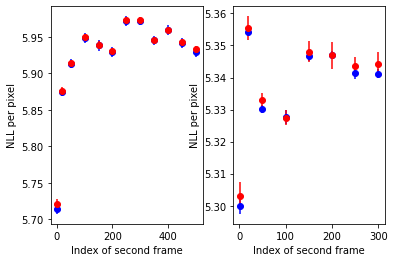

In [26]:
# minerl_ablation_linspace_elbo_db = [i for i in minerl_ablation_elbo_db if 'linspace' in i['config']['mode']]


def get_spacing_i_db(db, i, independent, with_rpe_net):
    mask_name = f"linspace-no-obs-0-{i}-2"
    if independent:
        mask_name = 'independent-'+mask_name
    return [run for run in db if run['config']['mode'] == mask_name if id_to_rpe_net[run['config']['wandb_id']] == with_rpe_net]

def plot(ax, x, runs, color, label, diff_to=None):
    values = np.array([first_n(run['data']['total_bpd'], 100).sum(axis=1).mean(axis=0) for run in runs])
    if diff_to is not None:
        diff_to_values = np.array([first_n(run['data']['total_bpd'], 100).sum(axis=1).mean(axis=0) for run in diff_to])
        values = diff_to_values - values
    ax.errorbar(np.array(x)+1, y=values.mean(), yerr=values.std(), color=color, label=label, fmt='o')
    

fig, axes = plt.subplots(ncols=2)
for ax, db in zip(axes, [minerl_ablation_elbo_db, mazes_ablation_elbo_db]):
    xs = [1, 19, 49, 99, 149, 199, 249, 299, 349, 399, 449, 499]  # 149, 249
    for x in xs:
        with_runs = get_spacing_i_db(db, x, independent=False, with_rpe_net=True)
        without_runs = get_spacing_i_db(db, x, independent=False, with_rpe_net=False)
        plot(ax, x, with_runs, color='b', label='With RPE network' if x==xs[0] else None)
        plot(ax, x, without_runs, color='r', label='Without RPE network' if x==xs[0] else None)

    ax.set_xlabel('Index of second frame')
    ax.set_ylabel('NLL per pixel')
#    ax.legend()
fig.savefig('figs/rpe-net-effect-vs-distance.pdf', bbox_inches='tight')

## Test NLLs for various different inference modes 

In [205]:
minerl_inf_mode_db = [i for i in metric_db if 'minerl-final-850k' in i['config']['subdirs']]
minerl_inf_mode_elbo_db = [i for i in elbo_db if 'minerl-final-850k' in i['config']['subdirs']]

mazes_inf_mode_db = [i for i in metric_db if 'mazes-final-950k' in i['config']['subdirs']]
mazes_inf_mode_elbo_db = [i for i in elbo_db if 'mazes-final-950k' in i['config']['subdirs']]

In [206]:
# for metric in ['mse', 'total_bpd']:
#     print('\nMetric:', metric)
#     to_show = {}
#     for run in minerl_inf_mode_db:
#         metrics = run['data']
#         path = run['path']
#         try:
#             elbo = first_n(metrics[metric], 100).sum(axis=1).mean(axis=0)  # TODO 100
#         except:
#             print('failed', path)
#         inf_mode = run['config']['mode']
#         to_show[f"{elbo:.2f} - {inf_mode}"] = elbo

#     for label, elbo in sorted(to_show.items(), key=lambda x: x[1]):
#         print(label)

## And test FVDs for the same runs

In [207]:
def print_mode_fvds(db):
    to_show = {}
    for run in db:
        metrics = run['data']['fvd']
        inf_mode = run['config']['mode']
        string = f"{format_mean_std(metrics.mean(), metrics.std()/np.sqrt(len(metrics)-1), len(metrics))} - {inf_mode}"
        to_show[string] = metrics.mean()
    for label, elbo in sorted(to_show.items(), key=lambda x: x[1]):
        print(label)
        
print('Mazes')
print_mode_fvds(mazes_inf_mode_db)

        
print('MineRL')
print_mode_fvds(minerl_inf_mode_db)

Mazes
53.11 +- 1.063 (5 seeds) - Hierarchy-2
53.70 +- 1.886 (5 seeds) - Hierarchy-3
54.97 +- 1.426 (5 seeds) - Adaptive hierarchy-2
64.49 +- 1.948 (5 seeds) - Mixed
86.44 +- 2.589 (5 seeds) - Autoregressive
MineRL
267.03 +- 4.026 (5 seeds) - Mixed
274.89 +- 7.660 (5 seeds) - Hierarchy-2
280.89 +- 10.174 (5 seeds) - Autoregressive
311.39 +- 6.826 (5 seeds) - Hierarchy-3
315.77 +- 8.899 (5 seeds) - Adaptive hierarchy-2


In [139]:
from numpy import array

a = array([54.80147818, 51.68201544, 56.26377283, 50.41206905, 52.407861  ])
print(a.mean(), a.std())

a = array([78.40920528, 91.71340571, 92.43377901, 84.29541665, 85.32933231])
print(a.mean(), a.std())

53.1134393 2.1268894114470154
86.43622779199998 5.1780422507487955


## And LPIPS vs distance for the same runs

In [140]:
_default_label_func = lambda x: f"{x['path'].parent.name}/{x['path'].stem}"


from scipy import stats
def smooth(x, std):
    # smooth a 1-D numpy array x
    gaussian_filter = stats.norm(0., 5.).pdf(np.arange(-5*std, 5*std))
    unnormed = np.convolve(x, gaussian_filter, 'same')
    norm_const = np.convolve(np.ones_like(x), gaussian_filter, 'same')
    return unnormed / norm_const


def do_plot(db, ax, mode, errorbar=True,
            label_func=_default_label_func,
            agg_mode="best",
            baseline_metrics=None, set_color=None,
            smooth_std=None, verbose=True):
    
    def agg_predictions(metric, agg_mode):
        assert agg_mode in ["best", "best_avg", "mean", "random"]
        best_fn = {"ssim": "max", "psnr": "max", "lpips": "min"}[mode]

        if agg_mode == "best":
            metric = getattr(metric[:, :2], best_fn)(axis=1)
        elif agg_mode == "best_avg":
            # Finding the order within samples wrt avg metric across time.
            order_metric = np.argsort(np.mean(metric, -1), axis=-1)
            assert best_fn in ["max", "min"]
            if best_fn == "max":
                metric = np.stack([metric[i, order[-1]] for (i, order) in enumerate(order_metric)])
            else:
                metric = np.stack([metric[i, order[0]] for (i, order) in enumerate(order_metric)])
        elif agg_mode == "random":
            metric = metric[:, 0, :]
        elif agg_mode == "mean":
            metric = metric.mean(axis=1)
        else:
            raise ValueError(f"Unknown aggregation mode {agg_mode}")
        return metric
    
    labels_seen = set()
    assert mode in ["ssim", "psnr", "lpips"]
    if label_func is None:
        label_func = lambda x: None
    for exp_data in db:
        path = str(exp_data["path"])
        metrics = exp_data["metrics"]
        if mode not in metrics:
            if verbose:
                print(f"Metrics {mode} not found in {path}")
            continue
        metric = agg_predictions(metrics[mode], agg_mode)

        mean = metric.mean(axis=0)
        if smooth_std is not None:
            mean = smooth(mean, smooth_std)
        std = metric.std(axis=0)
        label = None
        ls = '-'
        label = label_func(exp_data)
        
        color = set_color(path) if set_color is not None else None

        ax.plot(mean, label=None if label in labels_seen else label, color=color, ls=ls)
        labels_seen.add(label)
        if errorbar:
            ax.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.1)
    ax.grid("on")

NameError: name 'metrics_db' is not defined

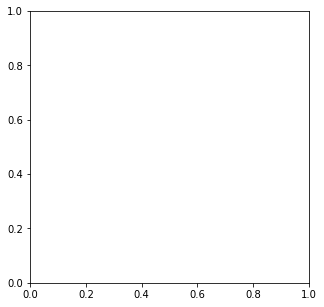

In [141]:
def set_color(path):
    if 'mixed' in path:
        return 'r'
    elif 'autoreg' in path:
        return 'b'
    elif 'really-independent' in path:
        return 'k'
    elif 'independent' in path:
        return 'g'
    elif 'cwvae' in path:
        return 'y'
def lpips_label_func(run):
    path = run['path']
    id = directory(path).parts[-2]
    return nice_mode_names[Path(directory(path)).parts[-1].split('_')[0]]
fig, ax = plt.subplots(figsize=(5, 5))
do_plot(metrics_db, ax, mode='lpips', errorbar=False, set_color=set_color,
       label_func=lpips_label_func, verbose=False, smooth_std=5)
ax.set_xlabel('Distance from originally observed frames')
ax.set_ylabel('Minimum LPIPS distance from ground truth (2 samples)')
ax.legend()

## FVD for various inference modes

In [ ]:
#fvds_runs = [(run['metrics']['fvd'].mean(), run) for run in inf_modes_db if 'fvd' in run['metrics'] and run['config']['T_pred']==300]
#fvds_runs = sorted(fvds_runs, key=lambda x: x[0])
#for fvd, run in fvds_runs:
#    fvd_str = f"{fvd:.2f} +- {run['metrics']['fvd'].std():.1f} ({run['metrics']['fvd'].shape[0]} seeds)"
#    id = run['path'].parts[-3]
#    print(f"{pad_to_len(fvd_str, 14)} - {pad_to_len(label_func(run), 40)} Trained with {run_names[id]}")

## FVD for ablations

In [ ]:
# fvds_runs = [(run['metrics']['fvd'].mean(), run) for run in ablations_db if 'fvd' in run['metrics'] and run['config']['T_pred']==300]
# fvds_runs = sorted(fvds_runs, key=lambda x: x[0])
# for fvd, run in fvds_runs:
#     fvd_str = f"{fvd:.2f} +- {run['metrics']['fvd'].std():.1f} ({run['metrics']['fvd'].shape[0]} seeds)"
#     id = run['path'].parts[-3]
#     print(f"{pad_to_len(fvd_str, 14)} - {pad_to_len(label_func(run), 30)} Trained with {run_names[id]}")

In [ ]:
mixed_db = [thing for thing in metrics_db if 'mixed' in str(thing['path'])]
autoreg_db = [thing for thing in metrics_db if 'autoreg_' in str(thing['path']) and 'mixed' not in str(thing['path'])]
independent_db = [thing for thing in metrics_db if 'independent_' in str(thing['path']) and 'mixed' not in str(thing['path'])]

## Autoreg

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
do_plot(autoreg_db, ax, mode='lpips', errorbar=False, set_color=None)
ax.legend()

## Mixed

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
do_plot(mixed_db, ax, mode='lpips', errorbar=False, set_color=None)
ax.legend()

## Independent

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
do_plot(independent_db, ax, mode='lpips', errorbar=False, set_color=None)
ax.legend()